In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import xarray as xr


In [ ]:
def multif_metrics(pred, obs, method='total', case=True, name=None):
    """Calculates RMSE and NSE metrics for xr.DataArray in the multiforecast
    shape as defined in the previous notebooks.
    Use case=True if the input data is in the form of a case study: multiple forecasts vor one set period.

    Parameters
    ----------
        pred   : xr.DataArray
        obs    : xr.DataArray
        case   : Boolean
        method : str
    """
    if method == 'total':
        y_o = obs.loc[{'time': pred.time.values.ravel()}].values
        y_m = pred.values.ravel()
        rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
        nse = 1 - np.sum((y_m - y_o)**2)/np.sum(((y_o - np.nanmean(y_o))**2))
        metr = xr.DataArray(data=np.array([rmse, nse]),
                            dims=['metric'],
                            coords=[['rmse', 'nse']],
                            name='total_metrics')

    elif method == 'per_day':
        forecast_range = pred.forecast_day
        fd_list = []
        for fd in forecast_range:
            pred_day = pred.sel(forecast_day=fd)
            y_o = obs.loc[{'time': pred_day.time.values.ravel()}].values
            y_m = pred_day.values.ravel()
            rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
            nse = 1 - np.sum((y_m - y_o)**2)/np.sum(((y_o - np.nanmean(y_o))**2))
            fd_list.append([rmse, nse])
        metr = xr.DataArray(data=np.array(fd_list),
                            dims=['forecast_day', 'metric'],
                            coords=[range(np.array(fd_list).shape[0]), ['rmse', 'nse']],
                            name='per_day_metrics')
    if name:
        metr.name = f"{name}-{metr.name}"
    return metr

In [ ]:
truth_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/glofas_groundtruth.nc')['dis']
fc_lr_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/LinReg_results.nc')['prediction']
fc_svr_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/SVR_results.nc')['prediction']
fc_gb_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/GradBoost_results.nc')['prediction']
# fc_tdnn_test = xr.open_dataset('../../data/models/TimeDelayNeuralNet/tdnn_result_test_period.nc')['prediction']
fc_knn_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/KNN_results.nc')['prediction']
fc_dt_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/DT_results.nc')['prediction']
fc_rf_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/RF_results.nc')['prediction']
fc_lasso_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/Lasso_results.nc')['prediction']
fc_ridge_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/Ridge_results.nc')['prediction']
fc_en_test = xr.open_dataset('/content/drive/MyDrive/499A/SavedFilesEra5/ElasticNet_results.nc')['prediction']

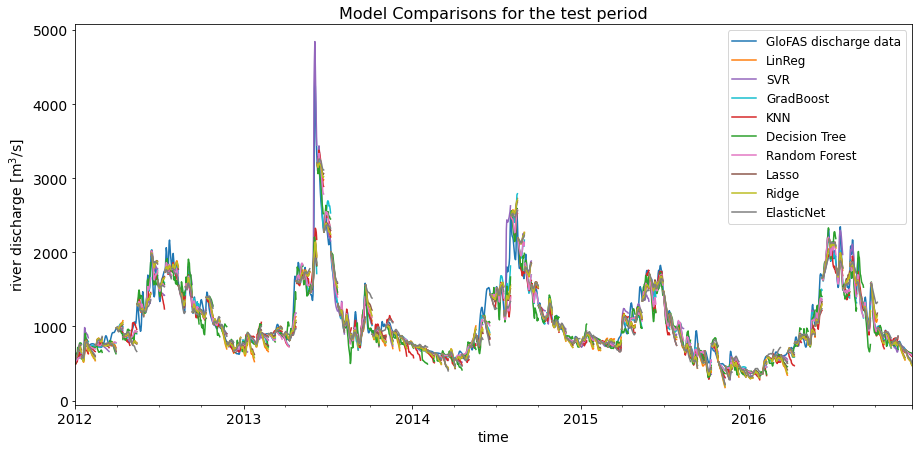

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(15, 7))
truth_test.to_pandas().plot(ax=ax, label='reanalysis')
cdict = {'LinReg': 'tab:orange',
         'SVR': 'tab:purple',
         'GradBoost': 'tab:cyan',
        #  'TimeDelay_neural_net': 'tab:green',
         'KNN': 'tab:red',
         'Decision Tree': 'tab:green',  #lightbrown
         'Random Forest': 'tab:pink',
         'Lasso': 'tab:brown',
         'Ridge': 'tab:olive',
         'ElasticNet': 'tab:gray'}
        #  'forecast_rerun_median': 'dimgray'}

for i in fc_lr_test.num_of_forecast:
    ind = i.values
    time_vec = truth_test.to_pandas().index[(ind-1)*15:ind*15]
    pd.Series(fc_lr_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='LinReg', color=cdict['LinReg'])
    pd.Series(fc_svr_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='SVR', color=cdict['SVR'])
    pd.Series(fc_gb_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='GradBoost', color=cdict['GradBoost'])
    pd.Series(fc_knn_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='KNN', color=cdict['KNN'])
    pd.Series(fc_dt_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='Decision Tree', color=cdict['Decision Tree'])
    pd.Series(fc_rf_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='Random Forest', color=cdict['Random Forest'])
    pd.Series(fc_lasso_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='Lasso', color=cdict['Lasso'])
    pd.Series(fc_ridge_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='Ridge', color=cdict['Ridge'])
    pd.Series(fc_en_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='ElasticNet', color=cdict['ElasticNet'])
    # pd.Series(fc_tdnn_test.sel(num_of_forecast=i).values, index=time_vec).plot(ax=ax, label='TimeDelay_neural_net', color=cdict['TimeDelay_neural_net'])

ax.set_ylabel('river discharge [m$^3$/s]')
plt.legend(['GloFAS discharge data', 'LinReg', 'SVR', 'GradBoost', 'KNN', 'Decision Tree', 'Random Forest', 'Lasso', 'Ridge', 'ElasticNet'], fontsize=12)   #add TD at the end
plt.title('Model Comparisons for the test period', fontsize=16);
plt.savefig('/content/drive/MyDrive/499A/SavedFilesEra5/model_comp.png', dpi=600, bbox_inches='tight')